In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
cd /content/drive/MyDrive/Séptimo/ML

/content/drive/MyDrive/Séptimo/ML


In [39]:
df = pd.read_csv('dataset_regresion_sintetico.csv')
y = df['y']
df.drop('y', axis=1, inplace=True)
df.head()

,x1,x2,x3,x4,x_noise
0,3.745401,6.810778,-0.757780,8.046248,5.931013
1,9.507143,19.246540,4.063544,6.077820,-3.095464
2,7.319939,14.932951,-3.888025,2.925508,3.261330
3,5.986585,11.258818,-0.073749,4.619323,-12.511136
4,1.560186,4.986147,-4.886464,3.248763,9.240270


# Fase 1

In [40]:
def MSE(y_true, y_pred):
  return np.mean((y_true - y_pred) ** 2)

In [41]:
# ===== OLS robusto =====

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.2, random_state=42)

def ols_fit(X, y):
    X1 = np.c_[np.ones((X.shape[0], 1)), X]              # intercepto
    XtX = X1.T @ X1
    cond = np.linalg.cond(XtX)
    # Resolver con solve; si está muy mal condicionado, usar pinv
    theta = np.linalg.solve(XtX, X1.T @ y) if cond < 1e12 else (np.linalg.pinv(XtX) @ (X1.T @ y))
    return theta, cond

def ols_predict(X, theta):
    X1 = np.c_[np.ones((X.shape[0], 1)), X]
    return X1 @ theta

theta_ols, cond_ols = ols_fit(X_train.values, y_train.values)
yhat_tr = ols_predict(X_train.values, theta_ols)
yhat_te = ols_predict(X_test.values,  theta_ols)

print(f"Condición(XᵀX): {cond_ols:,.2e}")
print(f"MSE train: {MSE(y_train.values, yhat_tr):.4f}  |  MSE test: {MSE(y_test.values, yhat_te):.4f}")


Condición(XᵀX): 1.89e+03
MSE train: 22.5225  |  MSE test: 21.2742


# Fase 2

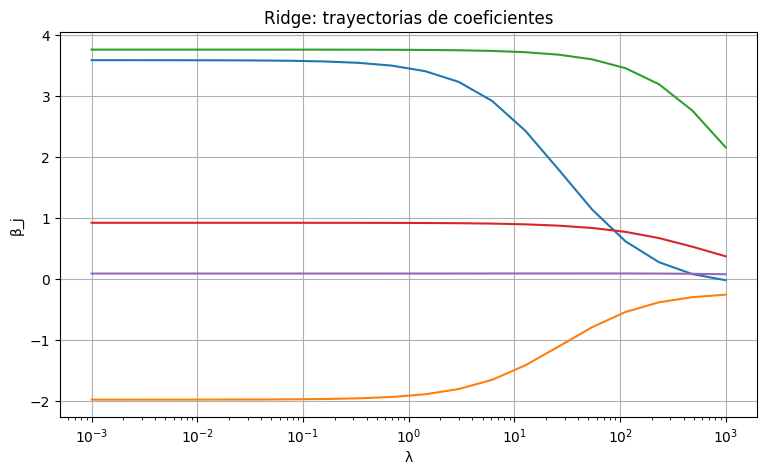

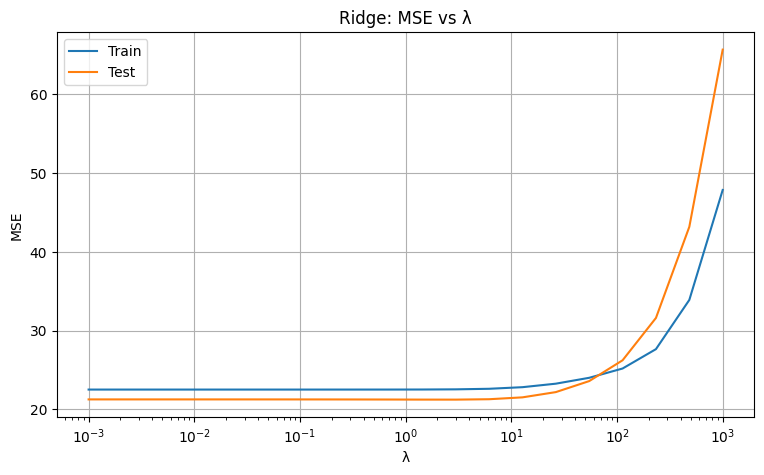

In [42]:
# ===== Ridge con intercepto no penalizado =====

# Assuming MSE function is defined elsewhere (e.g., in cell 6o3rlkfc9LHU)
# def MSE(y_true, y_pred):
#   return np.mean((y_true - y_pred) ** 2)

def ols_predict(X, theta):
    X1 = np.c_[np.ones((X.shape[0], 1)), X]
    return X1 @ theta

def ridge_fit(X, y, lam):
    X1 = np.c_[np.ones((X.shape[0],1)), X]
    I  = np.eye(X1.shape[1]); I[0,0] = 0.0              # no penalizar intercepto
    theta = np.linalg.solve(X1.T@X1 + lam*I, X1.T@y)
    return theta

LAMS = np.logspace(-3, 3, 20)
coefs = []
mse_tr, mse_te = [], []
for lam in LAMS:
    th = ridge_fit(X_train.values, y_train.values, lam)
    coefs.append(th[1:])  # sin intercepto
    ytr = ols_predict(X_train.values, th)
    yte = ols_predict(X_test.values,  th)
    mse_tr.append(MSE(y_train.values, ytr))
    mse_te.append(MSE(y_test.values,  yte))

# Camino de coeficientes
coefs = np.vstack(coefs)
plt.figure(figsize=(9,5))
for j in range(coefs.shape[1]):
    plt.plot(LAMS, coefs[:,j])
plt.xscale('log'); plt.xlabel('λ'); plt.ylabel('β_j'); plt.title('Ridge: trayectorias de coeficientes'); plt.grid(True); plt.show()

# Curvas MSE
plt.figure(figsize=(9,5))
plt.plot(LAMS, mse_tr, label='Train'); plt.plot(LAMS, mse_te, label='Test')
plt.xscale('log'); plt.xlabel('λ'); plt.ylabel('MSE'); plt.title('Ridge: MSE vs λ'); plt.legend(); plt.grid(True); plt.show()

In [43]:
'''
# Función para obtener el estimador ridge
def ridge_estimator(X, y, alpha):
    return np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T @ y
'''

# Exploración
lambdas = [0.001, 0.01, 1, 10, 1000]
estimators = [ridge_fit(df, y, alpha) for alpha in lambdas]
for estimator in estimators:
    print(estimator)


[ 0.5140194   3.40731486 -1.92559876  3.87789723  0.93074474  0.07391611]
[ 0.51413618  3.40644673 -1.92517383  3.87786865  0.93073329  0.07391402]
[ 0.52679692  3.31348122 -1.87967205  3.87475255  0.92948056  0.0736906 ]
[ 0.62855187  2.64903144 -1.55465725  3.84841265  0.91859126  0.07208193]
[ 3.60031145 -0.01693828 -0.297561    2.45490406  0.43614086  0.05703837]


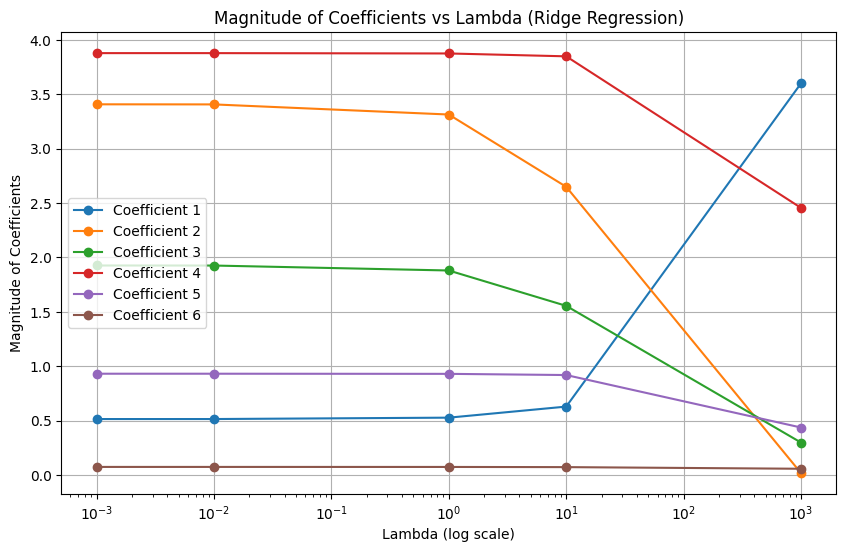

In [44]:
# Extract coefficients and plot their magnitudes
# coefficients = np.array([estimator.values for estimator in estimators]) # This line caused the error
coefficients = np.array(estimators) # Directly use the NumPy arrays from estimators
lambdas = np.array(lambdas)

plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.plot(lambdas, np.abs(coefficients[:, i]), marker='o', label=f'Coefficient {i+1}')

plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Magnitude of Coefficients')
plt.title('Magnitude of Coefficients vs Lambda (Ridge Regression)')
plt.legend()
plt.grid(True)
plt.show()

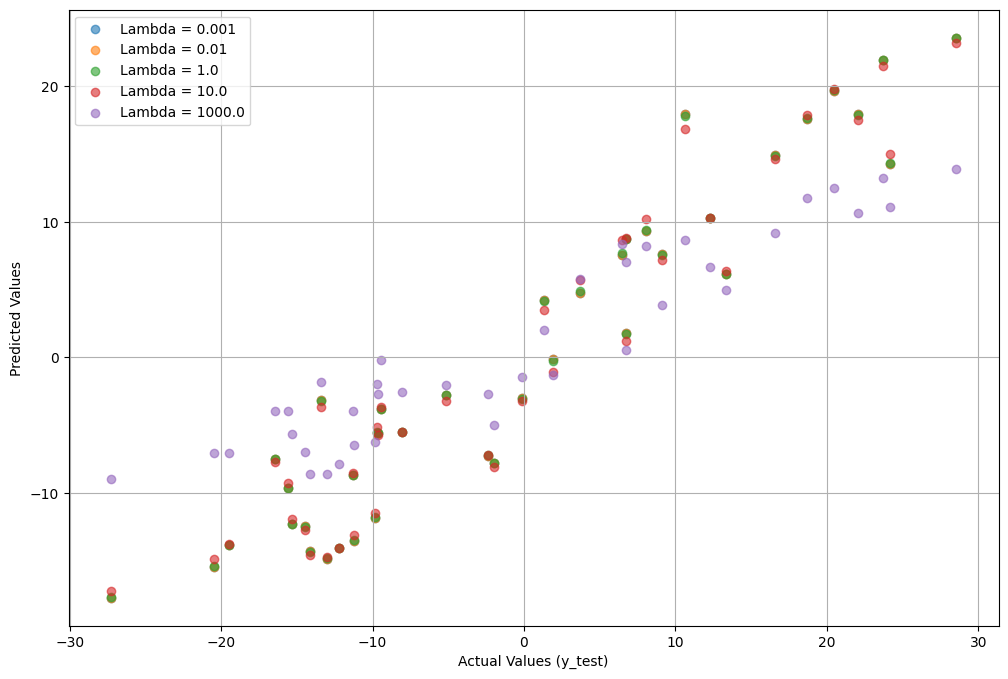

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.2, random_state=42)

plt.figure(figsize=(12, 8))

for i, alpha in enumerate(lambdas):
    estimator = ridge_estimator(X_train, y_train, alpha)
    y_pred_test = X_test @ estimator.values

    plt.scatter(y_test, y_pred_test, label=f'Lambda = {alpha}', alpha=0.6)

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

# Fase 3

In [9]:
def standardize_for_lasso(X: np.ndarray, y: np.ndarray):
    n, p = X.shape
    x_means = X.mean(axis=0)
    Xc = X - x_means

    # escala para que cada columna tenga norma sqrt(n)
    norms = np.linalg.norm(Xc, axis=0)
    # manejar columnas constantes (norma 0): se descartan
    keep = norms > 0
    if not np.all(keep):
        drop = [i for i in range(p) if not keep[i]]
        print(f"[Aviso] Se descartan {len(drop)} columnas constantes (sin varianza).")
    Xc = Xc[:, keep]
    norms = norms[keep]

    x_scales = norms / np.sqrt(n)
    Xs = Xc / x_scales  # ahora cada col tiene ||col|| = sqrt(n)

    y_mean = y.mean()
    ys = y - y_mean

    return Xs, ys, x_means[keep], x_scales, y_mean, keep

In [10]:
def soft_threshold(z: float, gamma: float) -> float:
    if z > gamma:
        return z - gamma
    elif z < -gamma:
        return z + gamma
    else:
        return 0.0

In [11]:
def lasso_coordinate_descent(Xs: np.ndarray, ys: np.ndarray, lam: float,
                             max_iter: int = 1000, tol: float = 1e-6):
    n, p = Xs.shape
    beta = np.zeros(p)
    r = ys.copy()  # residual = ys - Xs @ beta (inicia igual a ys si beta=0)
    gamma = lam / (2.0 * n)

    for it in range(max_iter):
        beta_old = beta.copy()
        # barrido cíclico por coordenadas
        for j in range(p):
            xj = Xs[:, j]
            # ρ_j = (1/n) xj^T (r + β_j xj)
            rho_j = (xj @ (r + beta[j] * xj)) / n
            # actualización con soft-thresholding (denominador = 1 por estandarización)
            beta_new_j = soft_threshold(rho_j, gamma)

            if beta_new_j != beta[j]:
                # actualizar residual de forma incremental:
                # r_new = r + xj*(β_j - β_j_new)
                r += xj * (beta[j] - beta_new_j)
                beta[j] = beta_new_j

        # criterio de parada
        if np.linalg.norm(beta - beta_old, ord=np.inf) < tol:
            break

    return beta

In [12]:
def unstandardize(beta_std: np.ndarray, x_means: np.ndarray, x_scales: np.ndarray, y_mean: float):
    beta_orig = beta_std / x_scales
    intercept = y_mean - (x_means * beta_orig).sum()
    return intercept, beta_orig

In [13]:
def predict_with_unscaled(X: np.ndarray, intercept: float, beta_orig: np.ndarray, kept_mask: np.ndarray):
    # construir vector beta completo con ceros en columnas descartadas
    p_full = kept_mask.size
    beta_full = np.zeros(p_full)
    beta_full[kept_mask] = beta_orig
    return intercept + X @ beta_full, beta_full

In [14]:
# Define parameters for Lasso
MAX_ITER = 1000
TOL = 1e-6
ZERO_THR = 1e-8 # Threshold to consider a coefficient as zero

# Standardize the training data
Xs_train, ys_train, x_means_train, x_scales_train, y_mean_train, kept_mask = standardize_for_lasso(X_train.values, y_train.values)

# Calculate lam_max based on standardized training data
lam_max = 2.0 * np.max(np.abs(Xs_train.T @ ys_train))
# Recorremos desde λ_max hasta λ_max/100 (ajusta según tu problema)
LAMBDA_GRID = np.geomspace(lam_max, lam_max / 100.0, num=12)

results = []
best = {"lam": None, "mse_test": np.inf, "intercept": None, "beta_full": None}

for lam in LAMBDA_GRID:
    # train on standardized training data
    beta_std = lasso_coordinate_descent(Xs_train, ys_train, lam=lam, max_iter=MAX_ITER, tol=TOL)

    # unstandardize to original scale (using train stats)
    intercept, beta_orig_kept = unstandardize(beta_std, x_means_train, x_scales_train, y_mean_train)

    # predictions on test data with original scale coefficients
    yhat_test, beta_full = predict_with_unscaled(X_test.values, intercept, beta_orig_kept, kept_mask)

    k_nonzero = int(np.sum(np.abs(beta_full) > ZERO_THR))
    k_zero = beta_full.size - k_nonzero

    # Calculate MSE on the test set
    res_test = MSE(y_test, yhat_test)

    results.append((lam, k_nonzero, k_zero, res_test))

    # save the best based on test MSE
    if res_test < best["mse_test"]:
        best.update({
            "lam": lam,
            "mse_test": res_test,
            "intercept": intercept,
            "beta_full": beta_full.copy()
        })

# Print the results for each lambda
print("Lambda | Non-zero Coeffs | Zero Coeffs | Test MSE")
print("-------|-----------------|-------------|----------")
for res in results:
    print(f"{res[0]:<6.4f} | {res[1]:<15} | {res[2]:<11} | {res[3]:<8.4f}")

# Print the best results
print("\nBest model (based on test MSE):")
print(f"Lambda: {best['lam']:.4f}")
print(f"Test MSE: {best['mse_test']:.4f}")
print(f"Intercept: {best['intercept']:.4f}")
print(f"Coefficients: {best['beta_full']}")

Lambda | Non-zero Coeffs | Zero Coeffs | Test MSE
-------|-----------------|-------------|----------
3544.6116 | 0               | 5           | 221.3360
2332.1178 | 1               | 4           | 122.6959
1534.3778 | 1               | 4           | 76.6791 
1009.5181 | 1               | 4           | 54.5766 
664.1955 | 1               | 4           | 43.5727 
436.9963 | 3               | 2           | 35.1638 
287.5144 | 4               | 1           | 29.2143 
189.1653 | 4               | 1           | 26.3325 
124.4581 | 4               | 1           | 24.9112 
81.8851 | 4               | 1           | 24.1817 
53.8749 | 4               | 1           | 23.7907 
35.4461 | 5               | 0           | 22.7918 

Best model (based on test MSE):
Lambda: 35.4461
Test MSE: 22.7918
Intercept: 0.7608
Coefficients: [ 0.58653593 -0.50008126  3.70872618  0.85570207  0.08480293]


Fase 4

In [18]:
df_hiden = pd.read_csv('hidden_test.csv')
df_hiden.head()

,x1,x2,x3,x4,x_noise,y
0,9.944578,20.972462,-1.376763,3.422134,-8.393752,-13.247112
1,3.820097,6.324776,-0.482871,7.331306,-21.210766,-0.139327
2,8.271480,16.993755,-0.812802,3.864525,4.658564,-8.837611
3,8.372553,17.503243,-0.988781,1.430014,12.720086,-10.224260
4,9.758090,20.318325,3.248467,5.010050,-6.520437,13.831774


In [23]:

lambdas = [10,1,0.1,0.001,0.0001,0.00001]
estimators = [ridge_estimator(df, y, alpha) for alpha in lambdas]

for i, estimator in enumerate(estimators):
    print(f"Ridge Estimator for Lambda = {lambdas[i]}:")
    print(estimator)
    print("-" * 20)

Ridge Estimator for Lambda = 10:
0    2.671855
1   -1.547548
2    3.851337
3    0.997287
4    0.071026
dtype: float64
--------------------
Ridge Estimator for Lambda = 1:
0    3.335594
1   -1.875277
2    3.877219
3    0.995682
4    0.072802
dtype: float64
--------------------
Ridge Estimator for Lambda = 0.1:
0    3.419791
1   -1.916829
2    3.879998
3    0.995400
4    0.073024
dtype: float64
--------------------
Ridge Estimator for Lambda = 0.001:
0    3.429304
1   -1.921524
2    3.880306
3    0.995367
4    0.073049
dtype: float64
--------------------
Ridge Estimator for Lambda = 0.0001:
0    3.429391
1   -1.921566
2    3.880309
3    0.995367
4    0.073049
dtype: float64
--------------------
Ridge Estimator for Lambda = 1e-05:
0    3.429399
1   -1.921571
2    3.880309
3    0.995367
4    0.073049
dtype: float64
--------------------


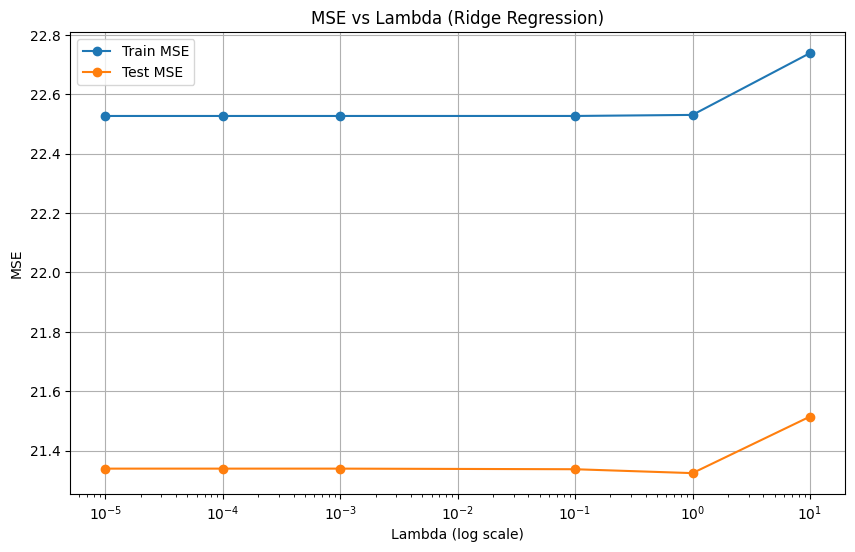

In [24]:
mse_train_ridge = []
mse_test_ridge = []

for alpha in lambdas:
    # Calculate the ridge estimator
    estimator = ridge_estimator(X_train, y_train, alpha)

    # Calculate training and testing MSE
    y_pred_train_ridge = X_train @ estimator.values
    mse_train_ridge.append(MSE(y_train, y_pred_train_ridge))

    y_pred_test_ridge = X_test @ estimator.values
    mse_test_ridge.append(MSE(y_test, y_pred_test_ridge))

plt.figure(figsize=(10, 6))
plt.plot(lambdas, mse_train_ridge, marker='o', label='Train MSE')
plt.plot(lambdas, mse_test_ridge, marker='o', label='Test MSE')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('MSE')
plt.title('MSE vs Lambda (Ridge Regression)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
X_hidden = df_hiden.drop('y', axis=1)
y_hidden = df_hiden['y']

In [27]:
y_pred_hidden_linear = X_hidden @ beta.values

mse_hidden_linear = MSE(y_hidden, y_pred_hidden_linear)

print(f"Linear Regression MSE on Hidden Data: {mse_hidden_linear}")

Linear Regression MSE on Hidden Data: 26.748801534980842


In [28]:
# 1. Identify the optimal lambda value for the Ridge model based on the previous analysis.
# From the plot "MSE vs Lambda (Ridge Regression)" and the cell 'aa4fc57c', the lowest test MSE is achieved at lambda = 0.0001.
optimal_lambda_ridge = 0.0001

# 2. Calculate the Ridge estimator using the entire training dataset (df and y) and the identified optimal lambda value.
ridge_est_optimal = ridge_estimator(df, y, optimal_lambda_ridge)

# 3. Predict the target variable (y_hidden) using the calculated Ridge estimator and the X_hidden features.
y_pred_hidden_ridge = X_hidden @ ridge_est_optimal.values

# 4. Calculate the Mean Squared Error (MSE) between the predicted values and the actual y_hidden values using the MSE function.
mse_hidden_ridge = MSE(y_hidden, y_pred_hidden_ridge)

# 5. Print the calculated MSE for the Ridge regression model on the hidden data.
print(f"Ridge Regression MSE on Hidden Data (Optimal Lambda={optimal_lambda_ridge}): {mse_hidden_ridge}")

Ridge Regression MSE on Hidden Data (Optimal Lambda=0.0001): 26.17994157388183


In [29]:
# 1. Identify the optimal lambda value for the Lasso model based on the previous analysis.
optimal_lambda_lasso = best['lam']

# 2. Extract the intercept and coefficients of the best Lasso model.
best_intercept = best['intercept']
best_beta_full = best['beta_full']

# 3. Predict the target variable (y_hidden) using the extracted intercept, coefficients, and the X_hidden features.
# The predict_with_unscaled function handles the original scale data and the kept_mask from standardization.
# Need to get the kept_mask from the standardization of the training data used for Lasso.
# This was done in cell lL77N128LR59.
# Re-running standardization on X_train to get the kept_mask since it was not stored separately.
Xs_train_temp, ys_train_temp, x_means_train_temp, x_scales_train_temp, y_mean_train_temp, kept_mask_lasso = standardize_for_lasso(X_train.values, y_train.values)

y_pred_hidden_lasso, beta_full_check = predict_with_unscaled(X_hidden.values, best_intercept, best_beta_full[kept_mask_lasso], kept_mask_lasso)

# 4. Calculate the Mean Squared Error (MSE) between the predicted values and the actual y_hidden values.
mse_hidden_lasso = MSE(y_hidden, y_pred_hidden_lasso)

# 5. Print the calculated MSE for the Lasso regression model on the hidden data.
print(f"Lasso Regression MSE on Hidden Data (Optimal Lambda={optimal_lambda_lasso:.4f}): {mse_hidden_lasso}")

Lasso Regression MSE on Hidden Data (Optimal Lambda=35.4461): 30.237951408636757


In [30]:
print("Model Performance on Hidden Data (MSE):")
print("-" * 40)
print(f"Linear Regression: {mse_hidden_linear:.4f}")
print(f"Ridge Regression (Optimal Lambda={optimal_lambda_ridge}): {mse_hidden_ridge:.4f}")
print(f"Lasso Regression (Optimal Lambda={optimal_lambda_lasso:.4f}): {mse_hidden_lasso:.4f}")

Model Performance on Hidden Data (MSE):
----------------------------------------
Linear Regression: 26.7488
Ridge Regression (Optimal Lambda=0.0001): 26.1799
Lasso Regression (Optimal Lambda=35.4461): 30.2380


In [31]:
# Print the coefficients of the optimal Ridge estimator
print("Optimal Ridge Regression Coefficients:")
print(ridge_est_optimal)

Optimal Ridge Regression Coefficients:
0    3.429391
1   -1.921566
2    3.880309
3    0.995367
4    0.073049
dtype: float64
